# M8 --- time series data 
#### Group members:  Zhihong Zhang


## Introduction 
In this practical challenge, I am going to explore a time series data set and create at least 3 different time-series model. 


For the steps I will use in this challenge, Exploratory data analysis(EDA) will be launched firstly, and based on the EDA, I will apply Data preparation which includes tiding invalid values, dealing with missing value, adding/removing features for modeling, etc. After Data Prep, the EDA will be relaunched to verify my process. 

After cleaning up the data set, model building can be done for the interest. Since this assignment only require to do data preparation, 
For the future work of this challenge, it can includes using general supervised machine learning tool to build an predictive model. 


##  Exploratory Data Analysis

The first thing of the task is to load the data set and check the rough view of these attributes. I got the whether data from Kaggle. https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data?select=DailyDelhiClimateTest.csv

In [24]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})


In [25]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.metrics import mean_squared_error


In [26]:


# check and read the dataset from github
df = pd.read_csv('https://raw.githubusercontent.com/steinszzh/AIProductStudio/master/M8/DailyDelhiClimateTrain.csv')

df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


Then the code was run to check the overview of the whole data set. And it is clear that there are 1462 rows of data.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


Also, we can tell there are no null values across whole dataset. 

In [28]:
#check null value 
df.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

This data frame have 1462 rows and 5 variables. 



Most variables are very straightforward and we knew what it means just through the column name. Also, since there is no missing value, we do not need to worry about the dealing time series mssing value.
 


In [29]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


Through the general sense of the value, we knew there were some invalid data points under meanpressure column since it is impossible to get negative pressure in weather data. Also, the maximum value of 7kpa is also not reasonable since it will be 7 times regular atomic pressure. We may use other algorithm to deal with these nonsense values. 

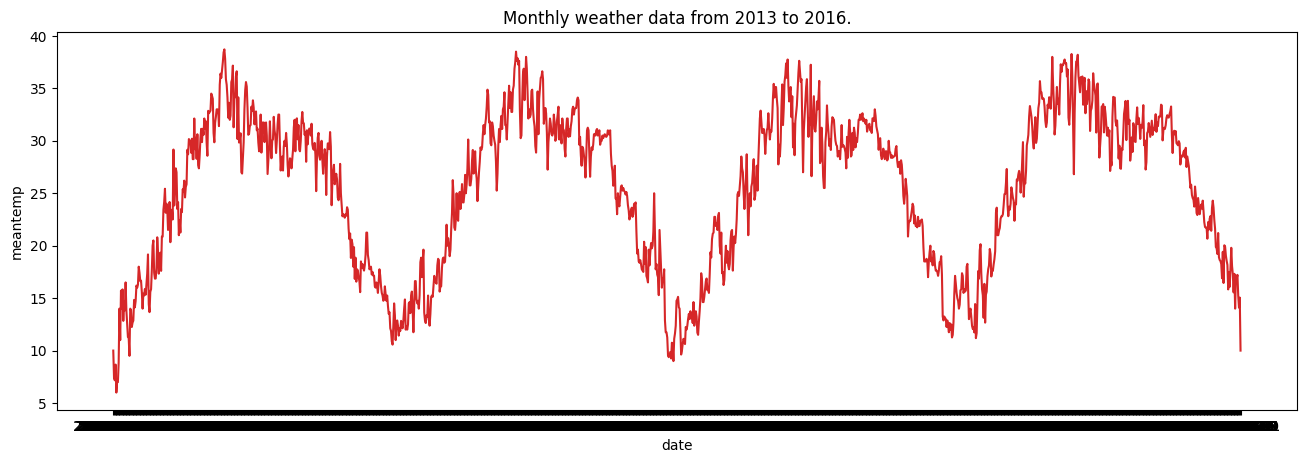

In [30]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='date', ylabel='meantemp', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()


plot_df(df, x=df.date, y=df.meantemp, title='Monthly weather data from 2013 to 2016.')   

Just through this ploting, we see it is a quite possible that the data is  stationary of the weather data. However, later we still need to use the statistical test to determine if a time series is stationary or not.

## Data Preparation & Prepped Data Review


During these section, we will follow our reference guidance to use moving average model to smooth our time series

### Moving average

In [31]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

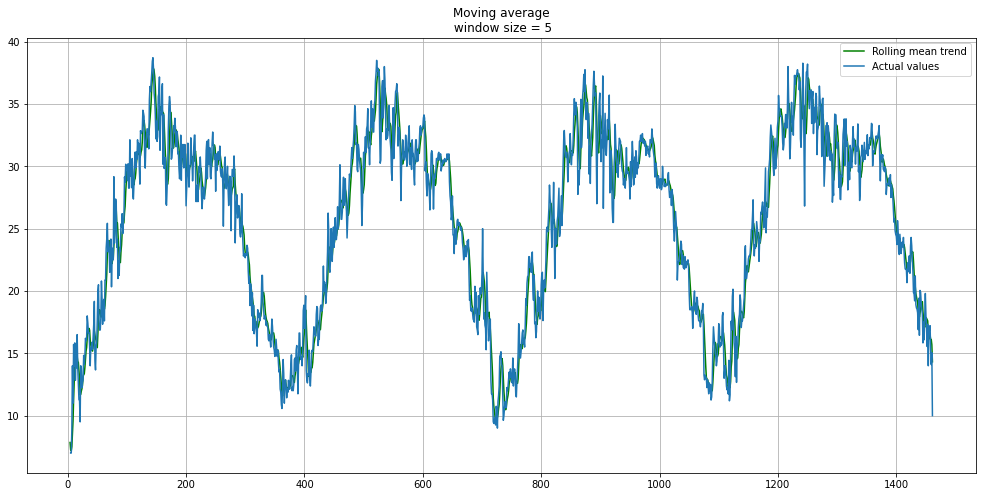

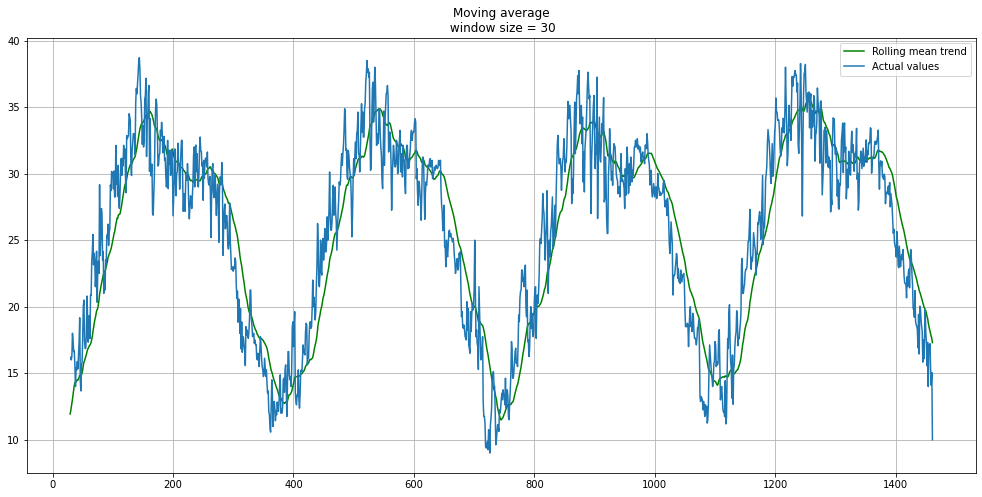

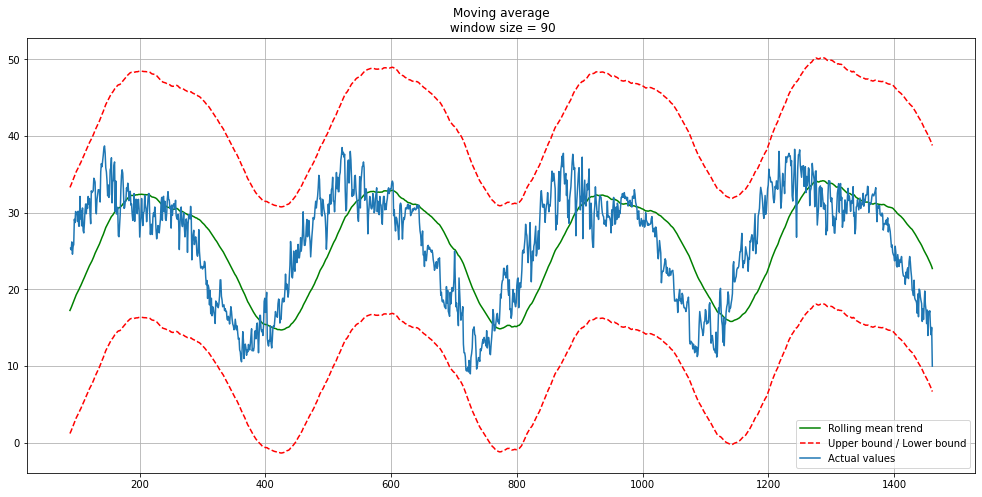

In [32]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(df.meantemp, 5)

#Smooth by the previous month (30 days)
plot_moving_average(df.meantemp, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(df.meantemp, 90, plot_intervals=True)

Based on the ploting graph, we knew this is a clear seasonaliity.

Although it is already clear enough, we can still use Exponential smoothing to check a clear trend

### Exponential Smoothing

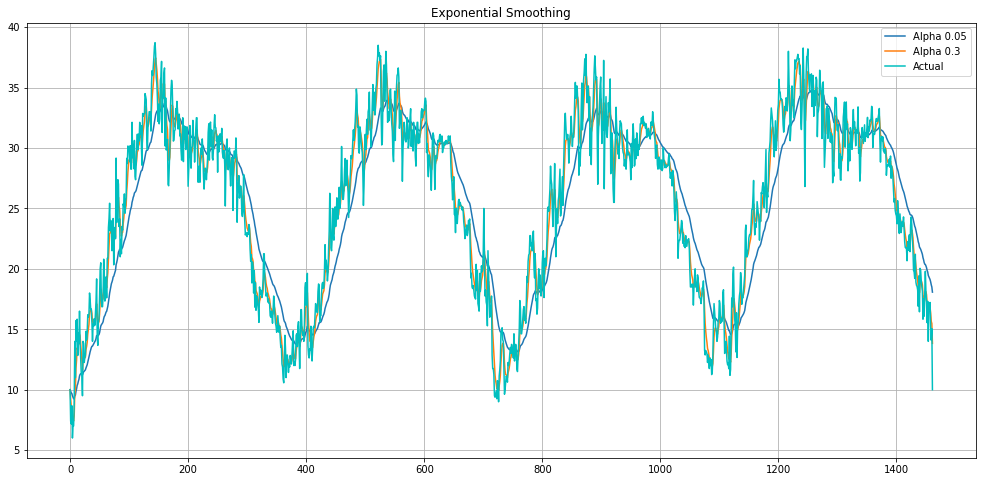

In [33]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(df.meantemp, [0.05, 0.3])

This smoothing curve well explained the most of the upward and downward trends. And finally, we introduce the double exponential smoothing.

### Double Exponential Smoothing

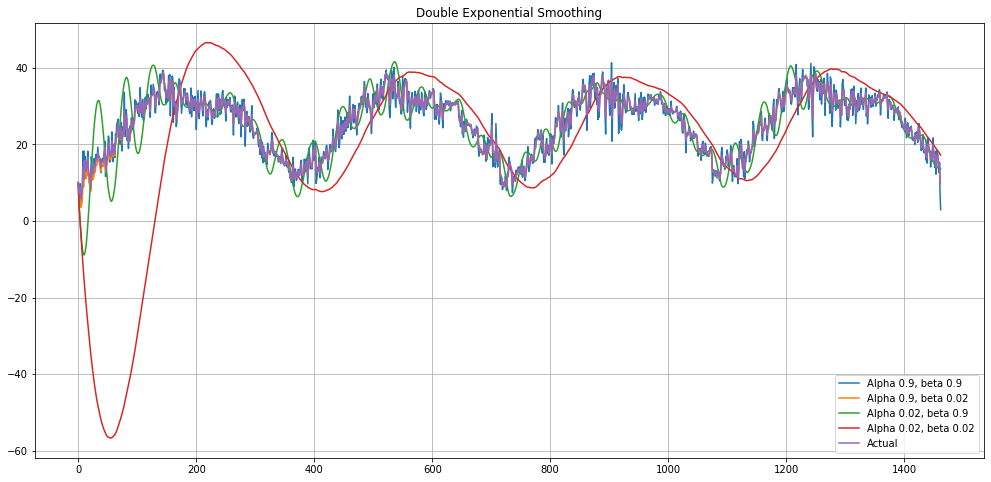

In [34]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(df.meantemp, alphas=[0.9, 0.02], betas=[0.9, 0.02])

As one of our 

Before we start to modeling, we need to apply the Dickey-Fuller test to see whether it is a stationary process or not

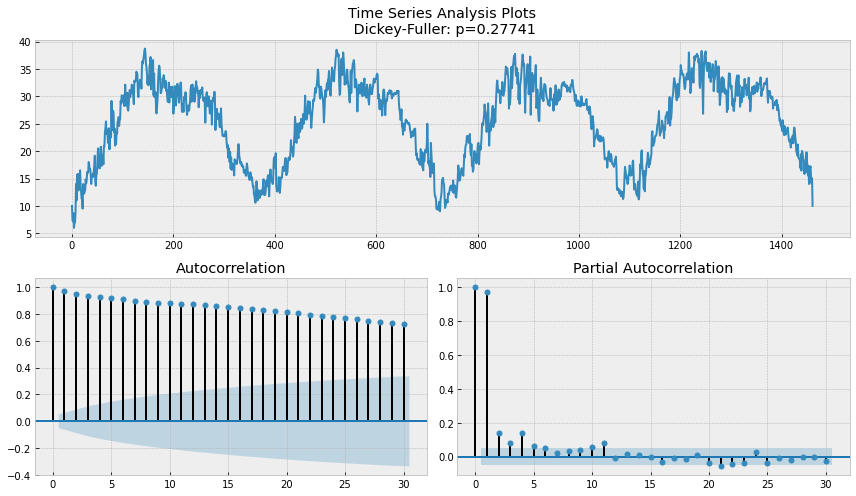

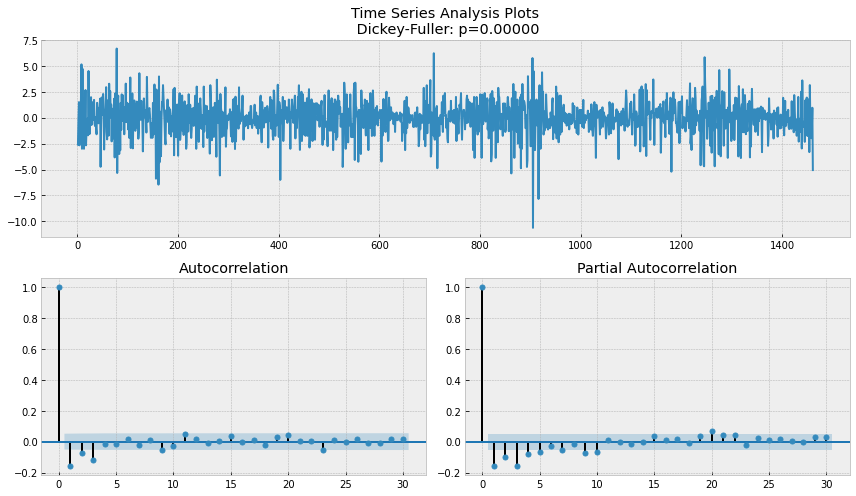

In [35]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df.meantemp, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = df.meantemp - df.meantemp.shift(1)

tsplot(data_diff[1:], lags=30)

In [36]:
#alternater way to check stationary
result = adfuller(df['meantemp'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -2.0210690559206714
p-value: 0.2774121372301609
Critical Values:
	1%: -3.4348647527922824
	5%: -2.863533960720434
	10%: -2.567831568508802


By the Dickey-Fuller test, the large p-value 0.27 indicates that the time series is not stationary. Then I follow the reference to get rid of high autocorrelation and to make process stationary. 

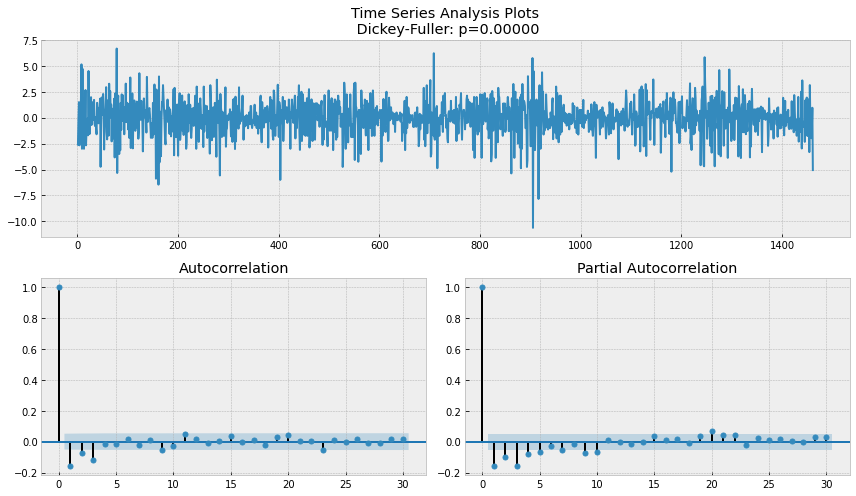

In [37]:
# Take the first difference to remove to make the process stationary
data_diff = df.meantemp - df.meantemp.shift(1)

tsplot(data_diff[1:], lags=30)

And based on the final result, now we can start to do the modeling.

## Modeling

Since we will not use meanpressure for modeling, we can avoid use it. 

In [38]:
#import test data for 2017

df_test = pd.read_csv('https://raw.githubusercontent.com/steinszzh/AIProductStudio/master/M8/DailyDelhiClimateTest.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


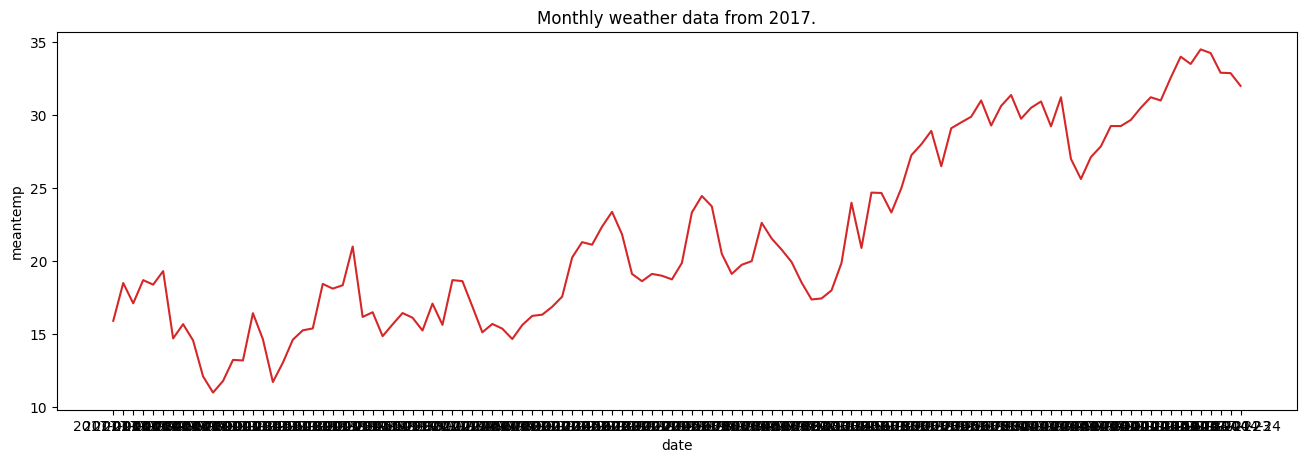

In [39]:

plot_df(df_test, x=df_test.date, y=df_test.meantemp, title='Monthly weather data from 2017.') 

Here I decided to use the model as follows:

AR, MA and ARMA. 


I start with ARIMA Model

In [44]:
df_log = np.log(df.meantemp)


In [40]:
#drop
df.drop(['humidity', 'wind_speed', 'meanpressure'], axis=1, inplace= True)
df.head()

,date,meantemp
0,2013-01-01,10.000000
1,2013-01-02,7.400000
2,2013-01-03,7.166667
3,2013-01-04,8.666667
4,2013-01-05,6.000000


Since I plan to only focus on temperature, I droped all other attributes.

In [45]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['meantemp'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [46]:
#make it stationary
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)

rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)

df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)

In [47]:
import statsmodels.api as sm
my_pandas_series = pd.Series([x%3 for x in range(100)])
decomposed = sm.tsa.seasonal_decompose(my_pandas_series.values, freq=3)

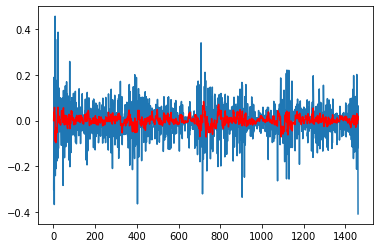

In [48]:


model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

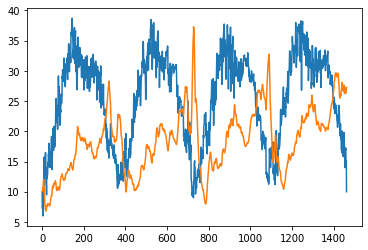

In [49]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log.iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df.meantemp)
plt.plot(predictions_ARIMA)

we add another year for prediction

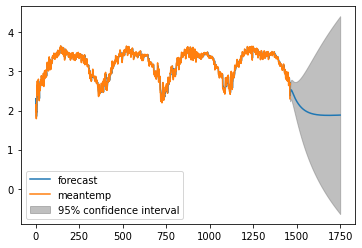

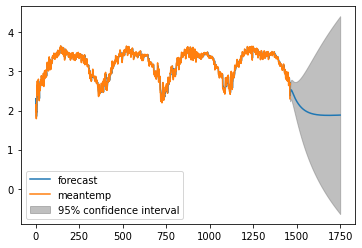

In [50]:
results.plot_predict(1,1750)

The prediction is definitely off the right range. 

Then we can compare with one extreme example which will drop all null values

Then I switched with other methods. I used AR model

Text(0.5, 1.0, 'RSS: 8.0307')

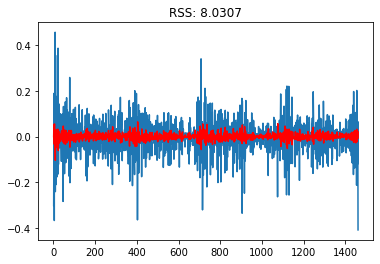

In [54]:
#AR Model
ARmodel = ARIMA(df_log, order=(2, 1, 0))  
results_AR = ARmodel.fit(disp=-1)  
plt.plot(df_log_shift)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-df_log_shift)**2))

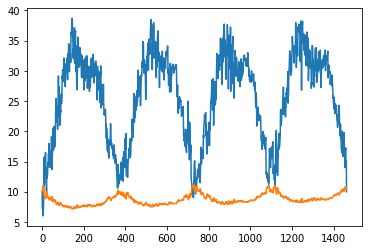

In [55]:
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
predictions_AR_log = pd.Series(df_log.iloc[0], index=df_log.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum, fill_value=0)
predictions_AR = np.exp(predictions_AR_log)
plt.plot(df.meantemp)
plt.plot(predictions_AR)

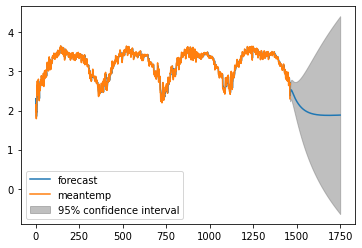

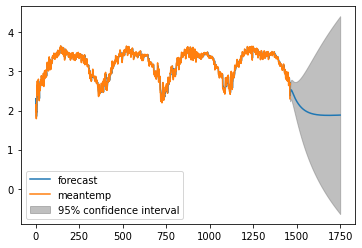

In [58]:
results.plot_predict(1,1750)

Text(0.5, 1.0, 'RSS: 7.9675')

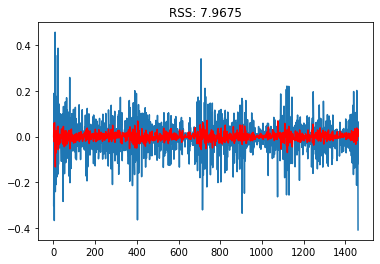

In [61]:
##MAmodel
MAmodel = ARIMA(df_log, order=(0, 1, 2))  
results_MA = MAmodel.fit(disp=-1)  
plt.plot(df_log_shift)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-df_log_shift)**2))





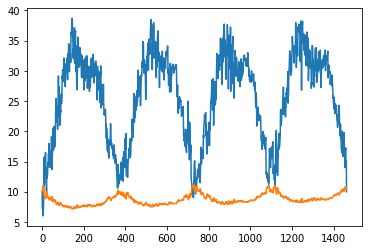

In [62]:
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
predictions_AR_log = pd.Series(df_log.iloc[0], index=df_log.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum, fill_value=0)
predictions_AR = np.exp(predictions_AR_log)
plt.plot(df.meantemp)
plt.plot(predictions_AR)

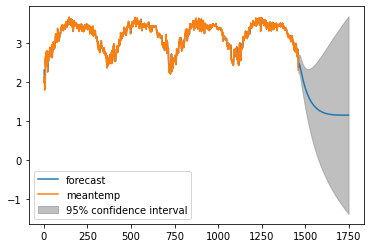

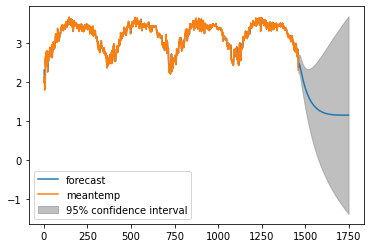

In [63]:
#plot prediction of 2017
results.plot_predict(1,1750)


## Conclusion

Based on the results , we can tell that modeling of ARIMA is not satsfying. Maybe some other deep learning method like LSTM can also be used for time series.

## References

1. Time series guide
https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775

